In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain, zip_longest
from collections import defaultdict
import pandas as pd
import glob
import json
import seaborn as sns
import scipy
from collections import Counter
import seaborn as sns
import statsmodels.api as sm
from matplotlib.patches import Patch

import glob
import random
import dill

chr_lengths = {1:643292,
               2:947102,
               3:1060087,
               4:1204112,
               5:1343552,
               6:1418244,
               7:1501717,
               8:1419563,
               9:1541723,
               10: 1687655,
               11:2038337,
               12:2271478,
               13:2895605,
               14:3291871,
               15:5967,
               16:100}

genome_size = 0.
for key in chr_lengths:
    genome_size +=chr_lengths[key]
        
        
class chromosome:
    def __init__(self):
        self.ibd = []
        self.dbd= []

def prepare_data(file):
    fin = open(file)
    data = [x.strip().split() for x in fin.readlines()]
    
    samples_dict = {}
    states_dict = {}
    samp1, samp2 = data[0][0], data[0][1]
    
    for line in data:
        if line[0] != samp1 or line[1] != samp2:
            samples_dict[samp1 + ':' + samp2] = states_dict
            samp1, samp2 = line[0], line[1]
            states_dict = {}

        chr = int(line[2])
        if chr == 15 or chr == 16:
            continue
        elif line[-1] == 'None':
            continue
        else:
            chr_positions = line[-2].split(',')[0:-1]
            states =  list(line[-1])
            if chr not in states_dict.keys():
                states_dict[chr] = [chr_positions, states]
            else:
                print('error')
                

    for comparison in samples_dict:
        states_dict = samples_dict[comparison]
        for key in states_dict:
            flip_points = []
            chr_positions = states_dict[key][0]
            states = states_dict[key][1]
        
            if states[0] == '0':
                flip_points.append(('IBD', 0))
            else:
                flip_points.append(('DBD', 0))
            
            for i, state in enumerate(states):
                if i != 0:
                    previous_state = states[i-1]
                else:
                    previous_state = states[0]
                
                if state == previous_state:
                    continue
                
                else:
                    if state == '0':
                        flip_points.append(('IBD', int(chr_positions[i])))
                    else:
                        flip_points.append(('DBD', int(chr_positions[i])))
            states_dict[key].append(flip_points)
    
    graph_samples_dict = {}
    graph_dict= {}
    for comparison in samples_dict:
        states_dict= samples_dict[comparison]
        for key in states_dict:
            chr = chromosome()
            for i, element in enumerate(states_dict[key][2]):
                if i != len(states_dict[key][2]) - 1:
                    if element[0] == 'IBD':
                        ibd_range = (element[1], states_dict[key][2][i+1][1] - element[1])
                        chr.ibd.append(ibd_range)
                    else:
                        dbd_range = (element[1], states_dict[key][2][i+1][1] - element[1])
                        chr.dbd.append(dbd_range)
                elif i == len(states_dict[key][2]) -1:
                    if element[0] == 'IBD':
                        ibd_range =(element[1],chr_lengths[key] - element[1])
                        chr.ibd.append(ibd_range)
                    else:
                        dbd_range =(element[1], chr_lengths[key] - element[1])
                        chr.dbd.append(dbd_range)
            graph_dict[key] = chr.__dict__
        graph_samples_dict[comparison] = graph_dict
        graph_dict = {}
    return graph_samples_dict

def calculate_coef_relatedness(ibd_segment_distance_dict, by_chrom = False):
    coef_relatedness = 0
    coef_relatedness_chrom = defaultdict(lambda: 0)
    for key in ibd_segment_distance_dict:
        for segment in ibd_segment_distance_dict[key]['ibd']:
            coef_relatedness += segment[1] /genome_size
            coef_relatedness_chrom[key] += segment[1]/chr_lengths[key]
        coef_relatedness_chrom[key] = round(coef_relatedness_chrom[key], 3)
    if by_chrom:
        return coef_relatedness_chrom
    else:
        return round(coef_relatedness,3)


def graph_broken_barh(ibd_segment_distance_dict):
    for key in ibd_segment_distance_dict: #key = chrom
        plt.broken_barh(ibd_segment_distance_dict[key]['ibd'] , (key-0.25, 0.5), facecolors='orange')
        plt.broken_barh(ibd_segment_distance_dict[key]['dbd'] , (key-0.25, .5), facecolors = 'grey')
    
    coef_relatedness = calculate_coef_relatedness(ibd_segment_distance_dict)
    plt.ylim(0,15)
    plt.yticks(np.arange(15))
    plt.xlabel('Position')
    plt.ylabel('Chromosome')
    plt.xscale('linear')
    plt.title(comparison)
    plt.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom='off',      # ticks along the bottom edge are off
                    top='off',         # ticks along the top edge are off
                    labelbottom='off')
    plt.annotate('prop_IBD={number}'.format(number = coef_relatedness),
             xy=(2e6,3),
             textcoords='data') 
    
def digitize_data(data, bins):
    data = np.asarray(data)
    #print(data)
    digitized = np.digitize(data, bins)
    bin_counts= Counter(digitized)

    totals = np.asarray([bin_counts[i] if i in bin_counts else 0.0 for i in range(1,len(bins)) ])
    #print(data[digitized == 0].mean()
    means = totals/np.sum(totals)
    #np.nan_to_num([data[digitized == i].mean() for i in range(1, len(bins))], nan = 0.0)
    normalized = means + 1e-6
    #print(normalized, bins)
    return np.asarray(normalized) / np.sum(normalized)



def generate_graph(ibd_segment_distance_dict):
    graph_broken_barh(ibd_segment_distance_dict)
    #plt.savefig(comparison + '.png')
    #plt.close()

def twolists(l1, l2):
    return sorted([x for x in chain(*zip_longest(l1, l2)) if x is not None], key = lambda x:x[0])

def find_short_segments(interleaved_list,chrom, threshold = 0.05):
    short_list = []
    for i,x in enumerate(interleaved_list):
        d = (x[1] - x[0]) / chr_lengths[chrom]
        if d < threshold:
            short_list.append((i, d))
    return short_list

def filter_short_segment(short_segment, interleaved_list):
    #print('starting filtration')
    filtered_ibd_segments=[]
    #short_segment = (index, length)
    index = short_segment[0]
    #print('initial interleaved list', interleaved_list)
    #print('distance', short_segment[1])
    #print('index', index, index-1, index + 1, len(interleaved_list) - 1)
    if (index != 0) and (index != len(interleaved_list)-1):
        preceding_segment = interleaved_list[index-1]
        post_segment = interleaved_list[index + 1]
        merged_segment = (preceding_segment[0], post_segment[1], preceding_segment[-1])
        #print(merged_segment)
        filtered_ibd_segments += interleaved_list[0:index-1] 
        filtered_ibd_segments += [merged_segment]
        filtered_ibd_segments += interleaved_list[index + 2:]
    elif index == 0:
        #print('start segment detected')
        post_segment = interleaved_list[index + 1]
        merged_segment = (interleaved_list[0][0], post_segment[1], post_segment[-1])
        filtered_ibd_segments += [merged_segment]
        filtered_ibd_segments += interleaved_list[index+2:]
    else:
        #print('end segment detected')
        preceding_segment = interleaved_list[index -1]
        filtered_ibd_segments += interleaved_list[0:index -1]
        merged_segment = (preceding_segment[0], interleaved_list[-1][1], preceding_segment[-1])
        filtered_ibd_segments += [merged_segment]
    #print('final interleaved_list', sorted(filtered_ibd_segments, key = lambda x:x[0]))
    return sorted(filtered_ibd_segments, key = lambda x:x[0])


def create_filtered_ibd_map(comparison,filter = True, threshold = 0.05):
    interleaved_segment_map = {}
    for chrom in graph_dict[comparison]:
        #print('chrom', chrom)
        ibd_l1 = [(x[0],x[0] + x[1],'ibd') for x in graph_dict[comparison][chrom]['ibd']]
        dbd_l1 = [(x[0],x[0] + x[1],'dbd') for x in graph_dict[comparison][chrom]['dbd']]
        interleaved_list = twolists(ibd_l1,dbd_l1) 
        if filter:
            short_list = find_short_segments(interleaved_list, chrom, threshold = 0.05)
            #print(short_list)
            kill_count = 0
            while len(short_list) > 0:
                #print(len(short_list))
                short_segment = short_list.pop(0)
                #print(short_segment)
                interleaved_list = filter_short_segment(short_segment, interleaved_list)
                short_list = find_short_segments(interleaved_list,chrom, threshold = 0.05)
                #print('fixed', interleaved_list)
                if kill_count > 10:
                    break
                kill_count += 1
        interleaved_segment_map[chrom] =interleaved_list
    return interleaved_segment_map

def reformat_interleaved_segment_map(interleaved_segment_map):
    segment_map_distance = defaultdict(lambda: defaultdict(list))
    for chrom in interleaved_segment_map:
        for segment in interleaved_segment_map[chrom]:
            segment_map_distance[chrom][segment[-1]].append((segment[0], segment[1]-segment[0]))
    return segment_map_distance
    

class Comparison:
    parental_strains =['KH004_2_019_H9/', 'Mal31/',
                     'MKK2835.2G/', 'NHP1337.12C/',
                     'AB_BSA_220_NF54.P','AB_BSA_222_NHP4026.P',
                      'AB_BSA_220_NF54','AB_BSA_222_NHP4026']
    def __init__(self, comparison):
        self.comparison = comparison
        self.s1 = comparison.split(':')[0]
        self.s2 = comparison.split(':')[1]
        self.threshold = 0.01
        self.type_sub = None
        if (self.s1 in Comparison.parental_strains) & (self.s2 in Comparison.parental_strains):
            self.type = 'PP'
        elif self.s1 in Comparison.parental_strains:
            self.type = 'PC'
            self.type_sub = self.s1
        elif self.s2 in Comparison.parental_strains:
            self.type = 'PC'
            self.type_sub = self.s2
            
        else:
            self.type = 'sibling'
        
                
        
        self.raw_ibd_graph = graph_dict[comparison]
        self.raw_interleaved_segment_map = create_filtered_ibd_map(comparison, False, threshold = self.threshold)
        self.raw_interleaved_segment_map_distance = reformat_interleaved_segment_map(self.raw_interleaved_segment_map)

        
        self.filtered_interleaved_segment_map = create_filtered_ibd_map(comparison, threshold = self.threshold)
        self.filtered_segment_map_distance = reformat_interleaved_segment_map(self.filtered_interleaved_segment_map)
        self.extract_statistics()
        
    def extract_statistics(self):
        self.filtered_relatedness = calculate_coef_relatedness(self.filtered_segment_map_distance)
        self.filtered_r_chrom = calculate_coef_relatedness(self.filtered_segment_map_distance, by_chrom = True)
        self.filtered_n_ibd_segments_dict = {}
        self.filtered_max_ibd_segment_dict = {}
        for chrom in self.filtered_interleaved_segment_map:
            segment_statuses = np.asarray([x[-1] for x in self.filtered_interleaved_segment_map[chrom]])
            segment_distances = np.asarray([x[1] - x[0] for x in self.filtered_interleaved_segment_map[chrom]])
            ibd_mask = segment_statuses == 'ibd'
            n_ibd_segments = np.sum(ibd_mask)
            if n_ibd_segments == 0:
                max_ibd_segment = 0
            else:
                max_ibd_segment = round(max(segment_distances[ibd_mask]) / chr_lengths[chrom],3)
            self.filtered_n_ibd_segments_dict[chrom] = n_ibd_segments
            self.filtered_max_ibd_segment_dict[chrom] = max_ibd_segment
            
        self.raw_relatedness = calculate_coef_relatedness(self.raw_ibd_graph)
        self.raw_r_chrom= calculate_coef_relatedness(self.raw_ibd_graph, by_chrom = True)
        self.raw_n_ibd_segments_dict = {}
        self.raw_max_ibd_segment_dict = {}
        for chrom in self.raw_interleaved_segment_map:
            segment_statuses = np.asarray([x[-1] for x in self.raw_interleaved_segment_map[chrom]])
            segment_distances = np.asarray([x[1] - x[0] for x in self.raw_interleaved_segment_map[chrom]])
            ibd_mask = segment_statuses == 'ibd'
            n_ibd_segments = np.sum(ibd_mask)
            if n_ibd_segments == 0:
                max_ibd_segment = 0
            else:
                max_ibd_segment = round(max(segment_distances[ibd_mask]) / chr_lengths[chrom],3)
            self.raw_n_ibd_segments_dict[chrom] = n_ibd_segments
            self.raw_max_ibd_segment_dict[chrom] = max_ibd_segment
    
    def return_stats(self,header=True):
        stats = [self.comparison, self.filtered_relatedness] + [self.filtered_n_ibd_segments_dict[chrom] for chrom in range(1,15)] + [self.filtered_max_ibd_segment_dict[chrom] for chrom in range(1,15)]
        if header:
            header = ['comparison','relatedness'] + ['{c}:max_ibd'.format(c=chrom) for chrom in range(1,15)] + ['{c}:n_ibd'.format(c=chrom) for chrom in range(1,15)]
            return [header, stats]
        else:
            return [stats]
        

In [2]:
graphs = {}
for file in glob.glob('*seq_ibdhmm_results.txt'):
    print(file)
    basename = ('_').join(file.split('_')[:-3])
    graphs[basename] = prepare_data(file)
graph_dict = {}
for basename in graphs:
    for k,v in graphs[basename].items():
        graph_dict[k] = v


MKK2835_NHP1337_seq_ibdhmm_results.txt
NF54_NHP4026_F2_seq_ibdhmm_results.txt
NF54_NHP4026_selection_seq_ibdhmm_results.txt
NF54_NHP4026_control_seq_ibdhmm_results.txt
Mal31xKH004_seq_ibdhmm_results.txt


In [291]:
def process_cross_data_comparisons(crosslist):
    relatedness_dict = {}
    for cross in crosslist:
        for comparison in graphs[cross]:
            relatedness_dict[comparison] = Comparison(comparison)
    return relatedness_dict

def recover_empirical_stats(G = 'PC', cross = 'MKK2835_NHP1337'):
    relatedness_distribution = defaultdict(list)
    n_ibd_segments_list = defaultdict(lambda: defaultdict(list))
    max_ibd_segment_list = defaultdict(lambda: defaultdict(list))
    r_chrom = defaultdict(lambda: defaultdict(list))
    for comparison in cross_comparisons_dict[cross]:
        if cross_comparisons_dict[cross][comparison].type ==G:
            #print(comparison, cross_comparisons_dict[cross][comparison].relatedness)
            relatedness_distribution['raw'].append(cross_comparisons_dict[cross][comparison].raw_relatedness)
            relatedness_distribution['filtered'].append(cross_comparisons_dict[cross][comparison].filtered_relatedness)
            
            for chromosome in range(1,15):
                n_ibd_segments_list['raw'][chromosome].append(cross_comparisons_dict[cross][comparison].raw_n_ibd_segments_dict[chromosome])
                max_ibd_segment_list['raw'][chromosome].append(cross_comparisons_dict[cross][comparison].raw_max_ibd_segment_dict[chromosome])

                n_ibd_segments_list['filtered'][chromosome].append(cross_comparisons_dict[cross][comparison].filtered_n_ibd_segments_dict[chromosome])
                max_ibd_segment_list['filtered'][chromosome].append(cross_comparisons_dict[cross][comparison].filtered_max_ibd_segment_dict[chromosome])
                r_chrom['filtered'][chromosome].append(cross_comparisons_dict[cross][comparison].filtered_r_chrom[chromosome])
    return (relatedness_distribution, max_ibd_segment_list,n_ibd_segments_list, r_chrom)


cross_comparisons_dict = {}
for cross in ['Mal31xKH004', 'MKK2835_NHP1337', 'NF54_NHP4026_control','NF54_NHP4026_selection']: 
    cross_comparisons_dict[cross] = process_cross_data_comparisons([cross])

cross_list =  ['MKK2835_NHP1337', 'NF54_NHP4026_control']
cross_comparisons_dict[('|').join(cross_list)] = process_cross_data_comparisons(cross_list)

cross_list =  ['Mal31xKH004', 'NF54_NHP4026_control']
cross_comparisons_dict[('|').join(cross_list)] = process_cross_data_comparisons(cross_list)

cross_list =  ['Mal31xKH004', 'MKK2835_NHP1337', 'NF54_NHP4026_control']
cross_comparisons_dict[('|').join(cross_list)] = process_cross_data_comparisons(cross_list)

pc_comparisons_dict, sib_comparisons_dict = {},{}
pc_stats,sib_stats = defaultdict(lambda : {}),defaultdict(lambda : {})


for cross in cross_comparisons_dict.keys():
    pc_comparisons_dict[cross] = [comparison for comparison in cross_comparisons_dict[cross] if cross_comparisons_dict[cross][comparison].type == 'PC']
    sib_comparisons_dict[cross] = [comparison for comparison in cross_comparisons_dict[cross] if cross_comparisons_dict[cross][comparison].type == 'sibling']
    pc_stats[cross]['relatedness'], pc_stats[cross]['max_ibd'], pc_stats[cross]['n_ibd'], pc_stats[cross]['r_chrom'] = recover_empirical_stats('PC', cross)
    sib_stats[cross]['relatedness'], sib_stats[cross]['max_ibd'], sib_stats[cross]['n_ibd'], sib_stats[cross]['r_chrom'] = recover_empirical_stats('sibling', cross)


#pc_relatedness_distribution, pc_max_ibd_segment, pc_n_ibd_segments,pc_r_chrom = recover_empirical_stats('PC')
#sib_relatedness_distribution, sib_max_ibd_segment, sib_n_ibd_segments, sib_r_chrom = recover_empirical_stats('sibling')
def create_jackknife_indexes(cross): 
    #jackknife resampling
    jackknife_exclusion_indexes = defaultdict(list)
    n_pc = len(pc_stats[cross]['relatedness']['filtered'])
    pc_scrambled_indexes =[x for x in range(n_pc)]
    random.shuffle(pc_scrambled_indexes)
    b1 = [x for x in range(0, n_pc + 1, int(n_pc/10.))]
    b2 = b1[1:]
    for start, stop in zip(b1,b2):
        jackknife_exclusion_indexes['pc'].append(pc_scrambled_indexes[start:stop])


    n_sib = len(sib_stats[cross]['relatedness']['filtered'])
    sib_scrambled_indexes =[x for x in range(n_sib)]
    random.shuffle(sib_scrambled_indexes)
    b1 = [x for x in range(0, n_sib + 1, int(n_sib/10.))]
    b2 = b1[1:]
    for start, stop in zip(b1,b2):
        jackknife_exclusion_indexes['sib'].append(sib_scrambled_indexes[start:stop])

    #with open('jackknife_exclusion_indexes.txt', 'wb') as fp:
    #    dill.dump(jackknife_exclusion_indexes, fp)

    #jackknife_exclusion_indexes = dill.load(open('jackknife_exclusion_indexes.txt', 'rb'))
    jackknife_inclusion_indexes = defaultdict(list)
    for indices in jackknife_exclusion_indexes['pc']:
        jackknife_inclusion_indexes['pc'].append([x for x in range(0,n_pc) if x not in indices])
    for indices in jackknife_exclusion_indexes['sib']:
        jackknife_inclusion_indexes['sib'].append([x for x in range(0,n_sib) if x not in indices])
    for key in ['pc', 'sib']:
        jackknife_inclusion_indexes[key] = np.asarray(jackknife_inclusion_indexes[key])
    print(cross, n_pc, n_sib)
    
    return jackknife_inclusion_indexes

In [292]:
jackknife_inclusion_indexes_dict = {}
for cross in cross_comparisons_dict.keys():
    jackknife_inclusion_indexes_dict[cross] = create_jackknife_indexes(cross)

Mal31xKH004 175 4073
MKK2835_NHP1337 66 564
NF54_NHP4026_control 174 3845
NF54_NHP4026_selection 77 747
MKK2835_NHP1337|NF54_NHP4026_control 240 4409
Mal31xKH004|NF54_NHP4026_control 349 7918
Mal31xKH004|MKK2835_NHP1337|NF54_NHP4026_control 415 8482


In [379]:
output =defaultdict(list)
for cross in cross_comparisons_dict:
    i= 0
    for C in cross_comparisons_dict[cross].values():
        if i == 0:
            output[cross] += C.return_stats(True)
        else:
            output[cross] += C.return_stats(False)
        i += 1
    output[cross] = pd.DataFrame(output[cross][1:], columns = output[cross][0])
    output[cross].to_csv(cross + '_comparison_stats.txt', sep = '\t', index = False)
    

In [5]:

meiosis_calibration_folder = 'meiosis_calibration/'

results = defaultdict(lambda : {})
for file in glob.glob(meiosis_calibration_folder + 'r_totals*'):
    split_file = file.split('_')
    v = split_file[-2]
    bp_per_chrom = split_file[-1].split('.')[0]
    param = v + '_' + bp_per_chrom
    results['r_total'][param] = json.load(open(file))
    
for file in glob.glob(meiosis_calibration_folder + 'r_chrom*'):
    split_file = file.split('_')    #print(split_file)
    v = split_file[-2]
    bp_per_chrom = split_file[-1].split('.')[0]
    param = v + '_' + bp_per_chrom
    results['r_chrom'][param] = json.load(open(file))
    
for file in glob.glob(meiosis_calibration_folder + 'ibd_segment_max*'):
    split_file = file.split('_')    #print(split_file)
    v = split_file[-2]
    bp_per_chrom = split_file[-1].split('.')[0]
    param = v + '_' + bp_per_chrom
    results['max_ibd_segment'][param] = json.load(open(file))
    
for file in glob.glob(meiosis_calibration_folder + 'ibd_segment_numbers*'):
    split_file = file.split('_')    #print(split_file)
    v = split_file[-2]
    bp_per_chrom = split_file[-1].split('.')[0]
    param = v + '_' + bp_per_chrom
    results['n_ibd_segment'][param] = json.load(open(file))
   

In [2]:
def generate_pileup(comparisons,cross):
    ibd_pileup = {}
    for chrom in range(1,15):
        ibd_pileup[chrom] = np.zeros(chr_lengths[chrom])
        for comparison in comparisons:
            for segment in cross_comparisons_dict[cross][comparison].filtered_interleaved_segment_map[chrom]:
                start,stop,status = segment
                if status == 'ibd':
                    ibd_pileup[chrom][start:stop] +=1
        ibd_pileup[chrom] = ibd_pileup[chrom] / len(comparisons)
    return ibd_pileup


In [413]:

def prepare_data_plots(G, cross, feature, chromosome):
    jackknifed_data = []
    if G == 'PC':
        G = 'pc'
        if feature != 'relatedness':
            raw_data = np.asarray(pc_stats[cross][feature]['filtered'][chromosome])
        else:
            raw_data = np.asarray(pc_stats[cross][feature]['filtered'])
    elif (G == 'FS') or (G == 'sib') or (G == 'sibling'):
        G = 'sib'
        if feature != 'relatedness':
            raw_data = np.asarray(sib_stats[cross][feature]['filtered'][chromosome])
        else:
            raw_data = np.asarray(sib_stats[cross][feature]['filtered'])
    
    for jackknife_indices in jackknife_inclusion_indexes_dict[cross][G]:
        jackknifed_data.append(np.asarray(raw_data)[jackknife_indices])
    return raw_data, jackknifed_data


def plot_n_ibd_segment_comparison(G, cross_list, v_list = [1,2], cM_list = [5,10,14], jackknife=False):
    plt.figure(figsize=(15,8))
    c_palette = sns.color_palette(palette = 'husl', n_colors= len(cM_list))
    c_palette_data = sns.color_palette('Blues', n_colors = len(cross_list))

    bins1 = np.arange(0,10 + 1, 1)
    roll_bins1 = bins1[1:]
    bins =[]
    for x,y in zip(bins1, roll_bins1):
        bins.append(np.mean([x,y]))
    for cross_idx, cross in enumerate(cross_list):
        for chromosome in range(1,15):
            plt.subplot(3,5,chromosome)
            for i,v in enumerate(v_list):
                raw_data, raw_jackknifed_data = prepare_data_plots(G, cross, 'n_ibd', chromosome)
                data = digitize_data(raw_data,bins1)
                jackknifed_data = [digitize_data(j, bins1) for j in raw_jackknifed_data]


                width = 1/(len(cM_list) + 2)
                for idx, search_cM in enumerate(cM_list):#range(5,15):
                    if search_cM != 'fn':
                        cM = search_cM * 1000
                    else:
                        cM = 'fn'

                    sim_results = digitize_data(results['n_ibd_segment']['{v}_{cM}'.format(v=v, cM = cM)][G][str(chromosome)],
                                                bins1)


                    plt.plot(bins, sim_results, color = c_palette[idx],linewidth =2)
                    plt.scatter(bins, sim_results, color = c_palette[idx])

            #plt.bar(x_axis, y_axis, color = 'grey', linewidth = 2, width = width, label = 'Data')
            plt.plot(bins, data,linewidth =3., color = c_palette_data[cross_idx], label = cross)
            if jackknife:
                for j in jackknifed_data:
                    plt.plot(bins, j, color = c_palette_data[cross_idx], alpha = 0.3)

            plt.title(chromosome, fontsize = 12)
            plt.ylabel('Density', fontsize = 12)
            plt.xlabel('IBD Segment Count', fontsize = 12)
    plt.suptitle(G + ': IBD Segment Count', fontsize = 15)

    plt.subplot(3,5,15)
    handles = []
    for cross_idx, cross in enumerate(cross_list):
        handles.append(Patch(facecolor = c_palette_data[cross_idx], label = cross))
    for i,search_cM in enumerate(cM_list):
        param = 'v={v} kbp/cM = {cM}'.format(v=v, cM=search_cM)
        handles.append(Patch(facecolor=c_palette[i], label=param))
    plt.legend(handles=handles)
    plt.axis('off')

    plt.tight_layout()

def plot_r_chrom_comparison(G, cross_list, v_list = [1,2], cM_list = [5,10,14], jackknife = False):
    plt.figure(figsize=(15,8))
    c_palette = sns.color_palette(palette = 'husl', n_colors= len(cM_list))
    c_palette_data = sns.color_palette('Blues', n_colors = len(cross_list))
    
    bins1 = np.arange(0, 1.01 + 0.1, 0.1)
    roll_bins1 = bins1[1:]
    bins =[]
    for x,y in zip(bins1, roll_bins1):
        bins.append(np.mean([x,y]))
    
    for cross_idx, cross in enumerate(cross_list):
        for chromosome in range(1,15):
            plt.subplot(3,5,chromosome)
            for i,v in enumerate(v_list):                
                raw_data, raw_jackknifed_data = prepare_data_plots(G, cross, 'r_chrom', chromosome)
                data = digitize_data(raw_data,bins1)
                jackknifed_data = [digitize_data(j, bins1) for j in raw_jackknifed_data]

                idx = 0
                for search_cM in cM_list:#range(5,15):
                    if search_cM != 'fn':
                        cM = int(search_cM * 1000)
                    else:
                        cM = 'fn'
                    sim_results = digitize_data(results['r_chrom']['{v}_{cM}'.format(v=v, cM = cM)][G][str(chromosome)],
                                               bins = bins1)
                    plt.plot(bins, sim_results, color = c_palette[idx],linewidth =2)
                    plt.scatter(bins, sim_results, color = c_palette[idx])




                    idx += 1
                plt.plot(bins, data, color = c_palette_data[cross_idx],linewidth = 3., label = cross)
                if jackknife:
                    for j in jackknifed_data:
                        plt.plot(bins, j, color = c_palette_data[cross_idx], alpha = 0.3)

            plt.title(chromosome, fontsize = 12)
            plt.ylabel('Density', fontsize = 12)
            plt.xlabel('Relatedness', fontsize = 12)
    plt.suptitle(G + ': Chromosomal Relatedness', fontsize = 15)
    plt.subplot(3,5,15)
    handles = []
    for cross_idx, cross in enumerate(cross_list):
        handles.append(Patch(facecolor = c_palette_data[cross_idx], label = cross))
    for i,search_cM in enumerate(cM_list):
        param = 'v={v} kbp/cM = {cM}'.format(v=v, cM=search_cM)
        handles.append(Patch(facecolor=c_palette[i], label=param))
    plt.legend(handles=handles)
    plt.axis('off')
    plt.tight_layout()
    
    
def plot_max_ibd_segment_comparison(G, cross_list, v_list = [1,2], cM_list = [5,10,14], jackknife = False):
    plt.figure(figsize=(15,8))
    c_palette = sns.color_palette(palette = 'husl', n_colors= len(cM_list))
    c_palette_data = sns.color_palette('Blues', n_colors = len(cross_list))
    bins1 = np.arange(0, 1.01 + 0.1, 0.1)

    roll_bins1 = bins1[1:]
    bins =[]
    for x,y in zip(bins1, roll_bins1):
        bins.append(np.mean([x,y]))
    
    for cross_idx, cross in enumerate(cross_list):
        for chromosome in range(1,15):
            plt.subplot(3,5,chromosome)
            for i,v in enumerate(v_list):
                raw_data, raw_jackknifed_data = prepare_data_plots(G, cross, 'max_ibd', chromosome)
                data = digitize_data(raw_data,bins1)
                jackknifed_data = [digitize_data(j, bins1) for j in raw_jackknifed_data]

                idx = 0
                for search_cM in cM_list:#range(5,15):
                    if search_cM != 'fn':
                        cM = int(search_cM * 1000)
                    else:
                        cM = 'fn'
                    sim_results = digitize_data(results['max_ibd_segment']['{v}_{cM}'.format(v=v, cM = cM)][G][str(chromosome)],
                                               bins = bins1)
                    #plt.hist(sim_results,color = c_palette[idx], label = 'v={v} kbp/cM = {cM}'.format(v=v, cM=cM), alpha = 0.3,
                    #        density = True)
                    #sns.histplot(sim_results, color = c_palette[idx], label = 'v={v} kbp/cM = {cM}'.format(v=v, cM=cM), alpha = 0.3,
                    #        fill= False)
                    plt.plot(bins, sim_results, color = c_palette[idx],linewidth =2)
                    plt.scatter(bins, sim_results, color = c_palette[idx])
                    idx += 1
                    
                plt.plot(bins, data, color = c_palette_data[cross_idx],linewidth = 3., label = cross)
                if jackknife:
                    for j in jackknifed_data:
                        plt.plot(bins, j, color = c_palette_data[cross_idx], alpha = 0.3)

            plt.title(chromosome, fontsize = 12)
            plt.ylabel('Density', fontsize = 12)
            plt.xlabel('Proportion Genome', fontsize = 12)
    plt.suptitle(G + ': Max IBD Segment', fontsize = 15)
    plt.subplot(3,5,15)
    handles = []
    for cross_idx, cross in enumerate(cross_list):
        handles.append(Patch(facecolor = c_palette_data[cross_idx], label = cross))
    for i,search_cM in enumerate(cM_list):
        param = 'v={v} kbp/cM = {cM}'.format(v=v, cM=search_cM)
        handles.append(Patch(facecolor=c_palette[i], label=param))
    plt.legend(handles=handles)
    plt.axis('off')


    plt.tight_layout()
    
def plot_relatedness_comparison(G, cross_list, v_list = [1,2], cM_list = [5,10,14], jackknife= False):
    bins1 = np.arange(0, 1.01 + 0.1, 0.1)
    roll_bins1 = bins1[1:]
    bins =[]
    for x,y in zip(bins1, roll_bins1):
        bins.append(np.mean([x,y]))
    c_palette = sns.color_palette(palette = 'husl', n_colors= len(cM_list))
    c_palette_data = sns.color_palette('Blues', n_colors = len(cross_list))
    
    for i,v in enumerate(v_list):
        idx = 0
        for search_cM in cM_list:
            if search_cM != 'fn':
                cM = int(search_cM * 1000)
            else:
                cM = 'fn'
            sim_results = digitize_data(results['r_total']['{v}_{cM}'.format(v=v, cM = cM)][G], bins1)
            plt.plot(bins, sim_results, color = c_palette[idx],linewidth =2)
            plt.scatter(bins, sim_results, color = c_palette[idx],label = 'v={v} kbp/cM = {cM}'.format(v=v, cM=cM))

            idx += 1

    
    for cross_idx, cross in enumerate(cross_list):
        print(G, cross)
        raw_data, raw_jackknifed_data = prepare_data_plots(G, cross, 'relatedness', 'placeholder')
        data = digitize_data(raw_data,bins1)
        jackknifed_data = [digitize_data(j, bins1) for j in raw_jackknifed_data]
        if jackknife:
            for j in jackknifed_data:
                plt.plot(bins, j, color = c_palette_data[cross_idx], alpha = 0.3)

        plt.plot(bins, data, color = c_palette_data[cross_idx],linewidth = 3., label = cross)
    plt.title('{G} Relatedness'.format(G=G, fontsize = 15))
    plt.ylabel('Density', fontsize = 12)
    plt.xlabel('Relatedness', fontsize = 12)
    plt.legend()
    plt.tight_layout()

        

In [332]:


def KL_divergence(v, kbp_cM, cross_list, chrom_range = range(1,15),jacknife_idx=None):
    bins1 = np.arange(0, 1.1 + 0.1, 0.1)
    #bins1 = np.arange(0,1.2 + 0.2, 0.2)
    bins2 = np.arange(0,10 + 1, 1)
    search_cM = kbp_cM
    D = 0
    
    for cross in cross_list:
        if kbp_cM == 'fn':
            cM = 'fn'
        else:
            cM = int(1000*kbp_cM)
        if jacknife_idx != None:
            pc_inclusion_indexes = np.asarray(jackknife_inclusion_indexes_dict[cross]['pc'][jacknife_idx])
            sib_inclusion_indexes = np.asarray(jackknife_inclusion_indexes_dict[cross]['sib'][jacknife_idx])
        else:
            pc_inclusion_indexes = np.asarray([x for x in range(len(pc_stats[cross]['relatedness']['filtered']))])
            sib_inclusion_indexes = np.asarray([x for x in range(len(sib_stats[cross]['relatedness']['filtered']))])


        pc_data_digitized_relatedness = digitize_data(np.asarray(pc_stats[cross]['relatedness']['filtered'])[pc_inclusion_indexes],
                                                      bins=bins1)
        pc_sim_digitized_relatedness = digitize_data(results['r_total']['{v}_{cM}'.format(v=float(v),
                                                            cM = cM)]['PC'],bins=bins1)

        #print('data', pc_data_digitized_relatedness)
        #print('sim', pc_sim_digitized_relatedness)
        D+= np.sum(scipy.special.kl_div(pc_data_digitized_relatedness, pc_sim_digitized_relatedness))


        fs_data_digitized_relatedness = digitize_data(np.asarray(sib_stats[cross]['relatedness']['filtered'])[sib_inclusion_indexes],bins=bins1)
        fs_sim_digitized_relatedness = digitize_data(results['r_total']['{v}_{cM}'.format(v=float(v), cM = cM)]['FS'],
                            bins=bins1)
        #print('data', fs_data_digitized_relatedness)
        #print('sim', fs_sim_digitized_relatedness)
        D += np.sum(scipy.special.kl_div(fs_data_digitized_relatedness, fs_sim_digitized_relatedness))

        for chromosome in chrom_range:
            #r_chrom
            #pc_data_digitized_r_chrom = digitize_data(np.asarray(pc_stats[cross]['r_chrom']['filtered'][chromosome])[pc_inclusion_indexes], bins = bins1)
            #pc_sim_digitized_r_chrom = digitize_data(results['r_chrom']['{v}_{cM}'.format(v=v, cM = cM)]['PC'][str(chromosome)],bins=bins1)

            #D+= np.sum(scipy.special.kl_div(pc_data_digitized_r_chrom, pc_sim_digitized_r_chrom))

            #sib_data_digitized_r_chrom = digitize_data(np.asarray(sib_stats[cross]['r_chrom']['filtered'][chromosome])[pc_inclusion_indexes], bins = bins1)
            #sib_sim_digitized_r_chrom = digitize_data(results['r_chrom']['{v}_{cM}'.format(v=v, cM = cM)]['FS'][str(chromosome)],bins=bins1)
            #+= np.sum(scipy.special.kl_div(sib_data_digitized_r_chrom, sib_sim_digitized_r_chrom))

            #maxibd
            pc_data_digitized_maxibd = digitize_data(np.asarray(pc_stats[cross]['max_ibd']['filtered'][chromosome])[pc_inclusion_indexes], bins = bins1)
            pc_sim_digitized_maxibd = digitize_data(results['max_ibd_segment']['{v}_{cM}'.format(v=v, cM = cM)]['PC'][str(chromosome)],
                            bins=bins1)
            D += np.sum(scipy.special.kl_div(pc_data_digitized_maxibd, pc_sim_digitized_maxibd))

            sib_data_digitized_maxibd = digitize_data(np.asarray(sib_stats[cross]['max_ibd']['filtered'][chromosome])[sib_inclusion_indexes], bins = bins1)
            sib_sim_digitized_maxibd = digitize_data(results['max_ibd_segment']['{v}_{cM}'.format(v=v, cM = cM)]['FS'][str(chromosome)],
                            bins=bins1)
            D += np.sum(scipy.special.kl_div(sib_data_digitized_maxibd, sib_sim_digitized_maxibd))

            pc_data_digitized_nibd = digitize_data(np.asarray(pc_stats[cross]['n_ibd']['filtered'][chromosome])[pc_inclusion_indexes],bins = bins2)
            pc_sim_digitized_nibd = digitize_data(results['n_ibd_segment']['{v}_{cM}'.format(v=v, cM = cM)]['PC'][str(chromosome)],
                                               bins = bins2)
            D += np.sum(scipy.special.kl_div(pc_data_digitized_nibd, pc_sim_digitized_nibd))

            sib_data_digitized_nibd = digitize_data(np.asarray(sib_stats[cross]['n_ibd']['filtered'][chromosome])[sib_inclusion_indexes], bins = bins2)
            sib_sim_digitized_nibd = digitize_data(results['n_ibd_segment']['{v}_{cM}'.format(v=v, cM = cM)]['FS'][str(chromosome)],
                            bins=bins2)
            D += np.sum(scipy.special.kl_div(sib_data_digitized_nibd, sib_sim_digitized_nibd))
    return D
        
        
    

PC MKK2835_NHP1337
PC NF54_NHP4026_control
PC Mal31xKH004
FS MKK2835_NHP1337
FS NF54_NHP4026_control
FS Mal31xKH004


/var/folders/27/jdv7q8tn02v65x59xkkym7kr0000gn/T/ipykernel_65003/2510863279.py:226: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


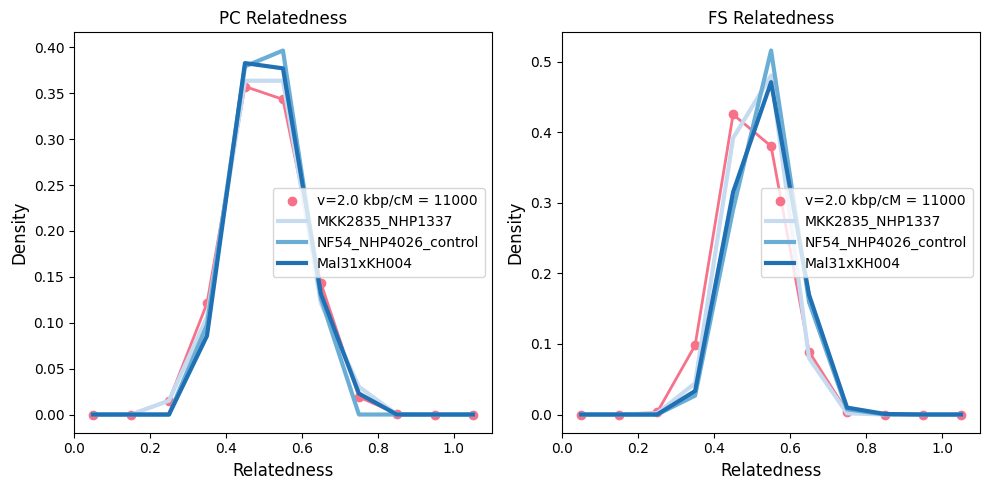

In [412]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_relatedness_comparison('PC',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11])
plt.subplot(1,2,2)
plot_relatedness_comparison('FS',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11])

PC MKK2835_NHP1337
PC NF54_NHP4026_control
PC Mal31xKH004
FS MKK2835_NHP1337
FS NF54_NHP4026_control
FS Mal31xKH004


/var/folders/27/jdv7q8tn02v65x59xkkym7kr0000gn/T/ipykernel_65003/3514306778.py:226: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


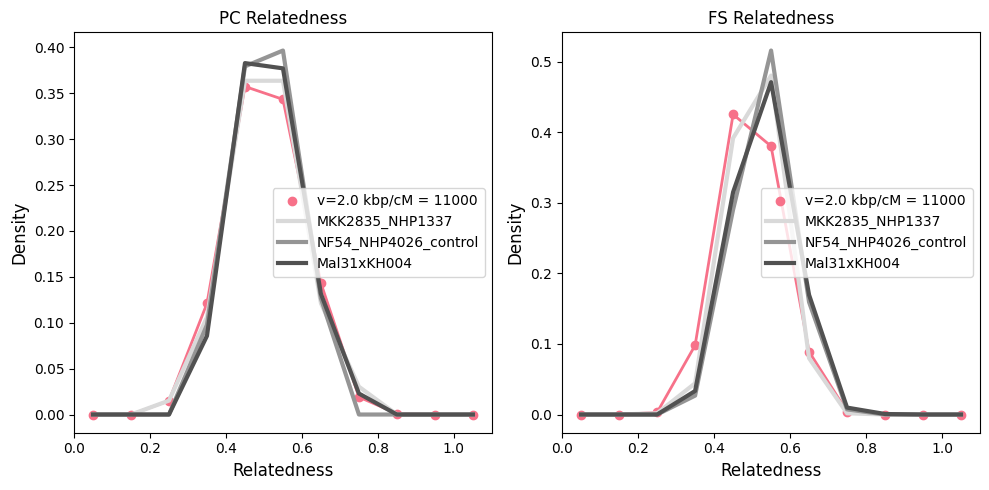

In [399]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_relatedness_comparison('PC',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11])
plt.subplot(1,2,2)
plot_relatedness_comparison('FS',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11])

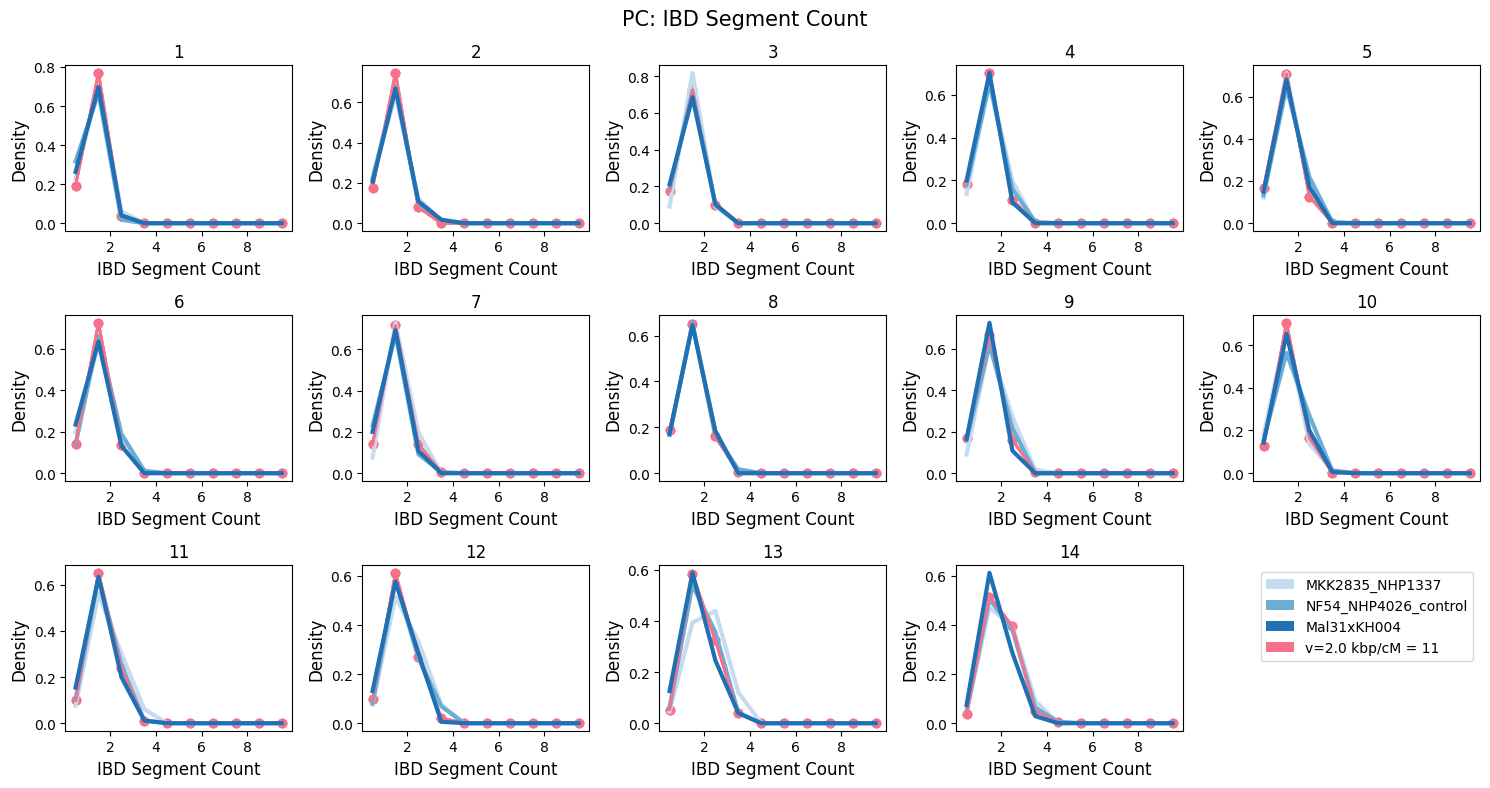

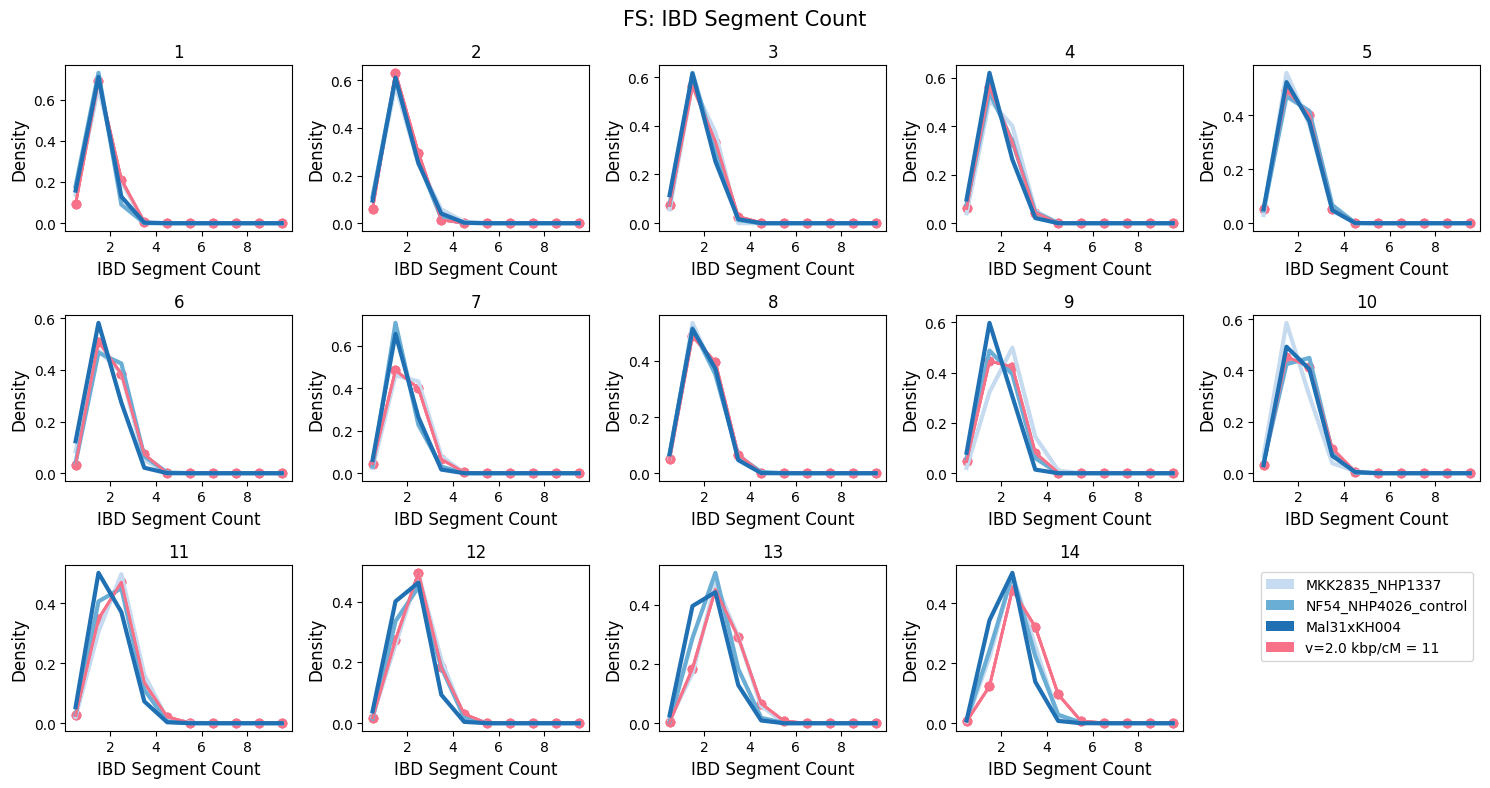

In [414]:
plot_n_ibd_segment_comparison('PC',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11])
plot_n_ibd_segment_comparison('FS',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11])


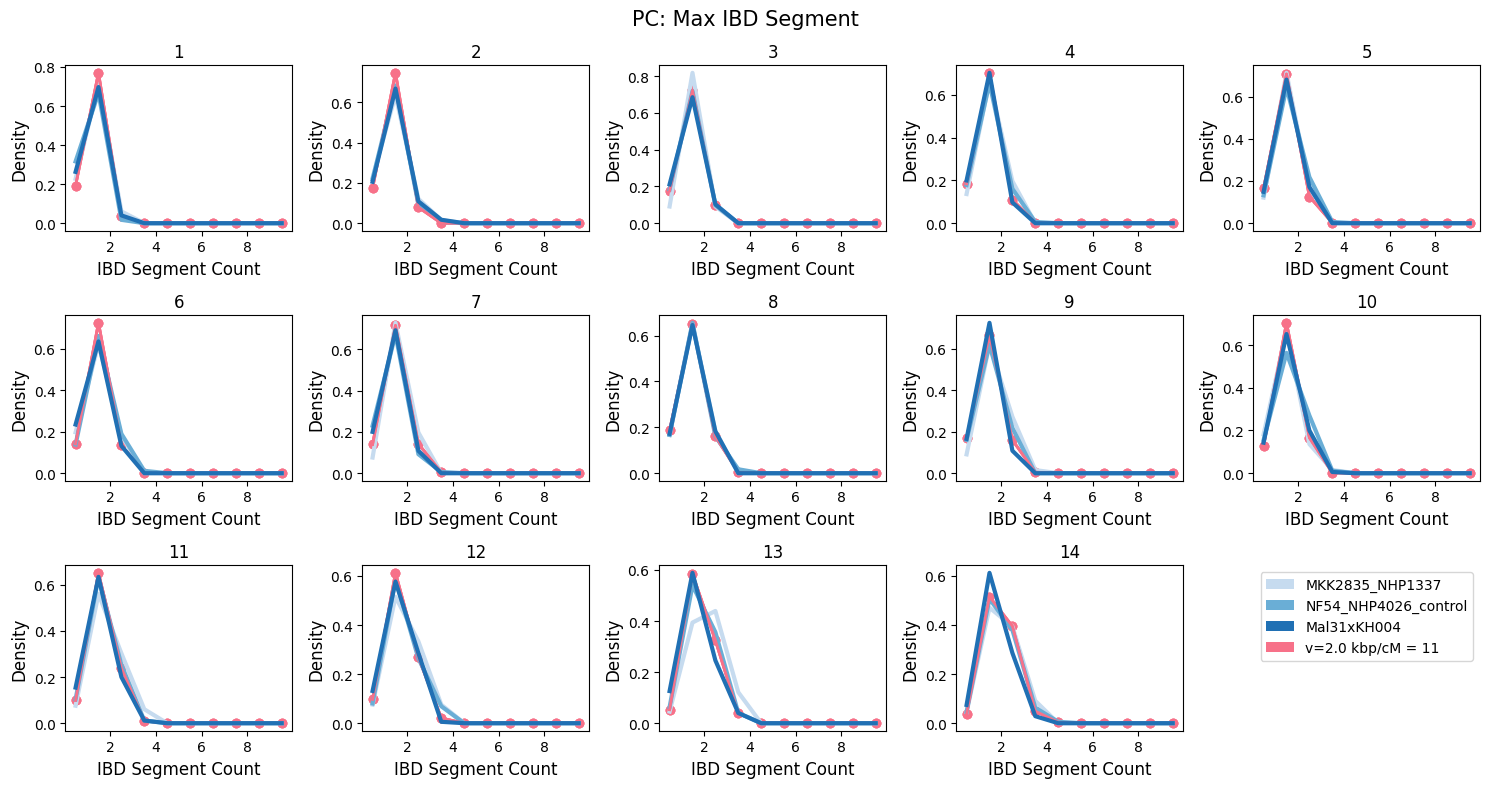

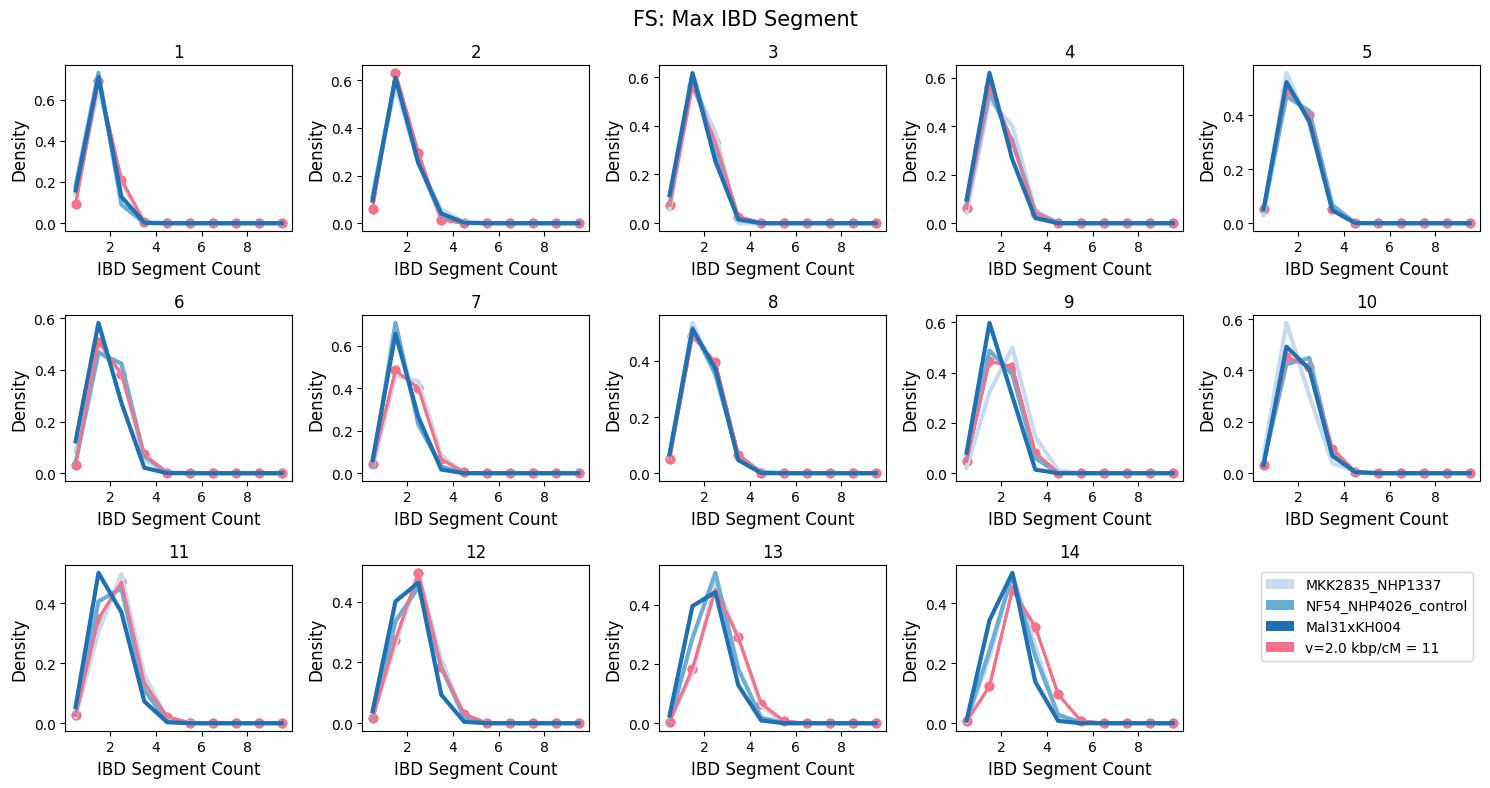

In [386]:
plot_n_ibd_segment_comparison('PC',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11])
plot_n_ibd_segment_comparison('FS',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11])


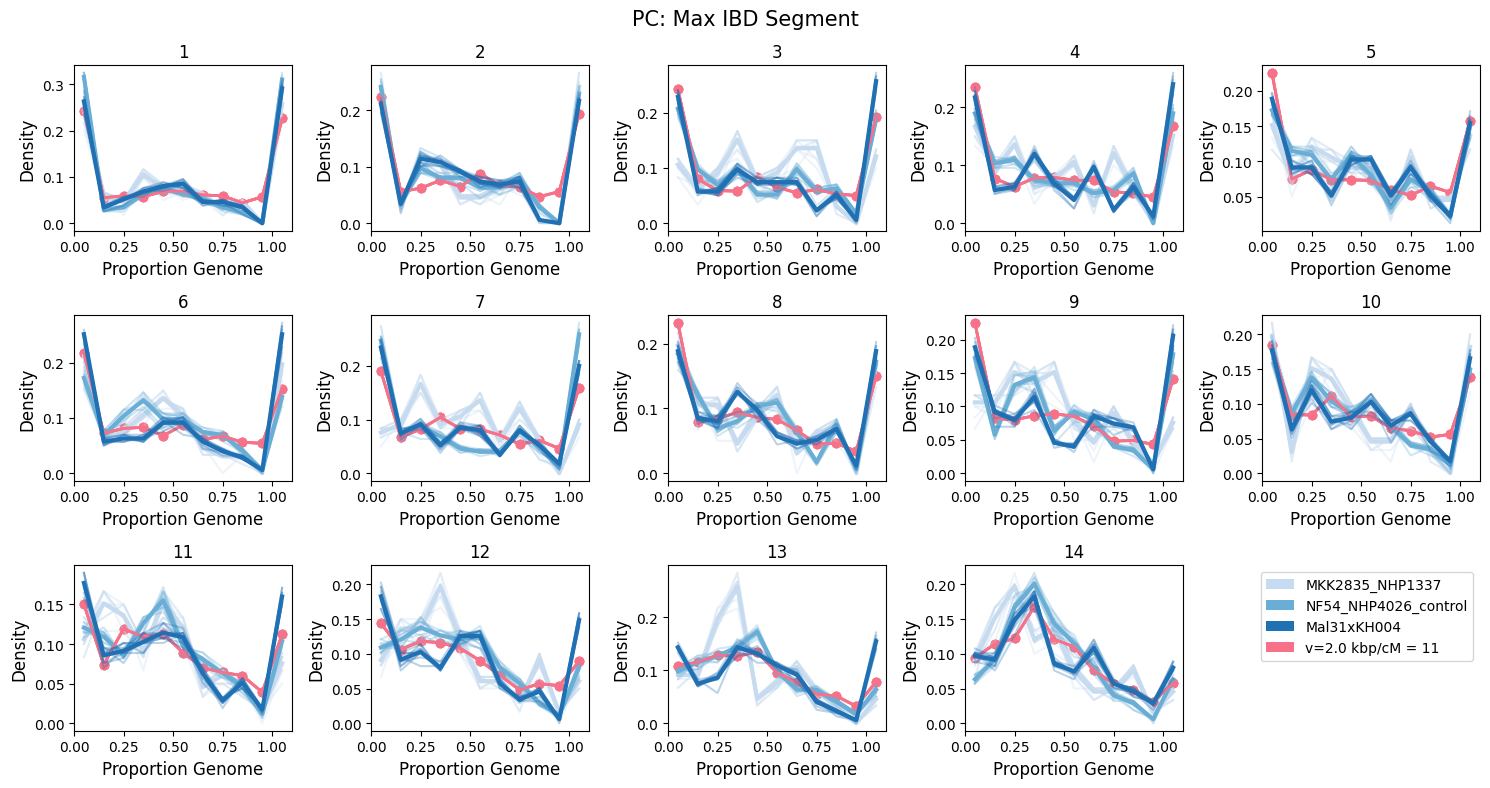

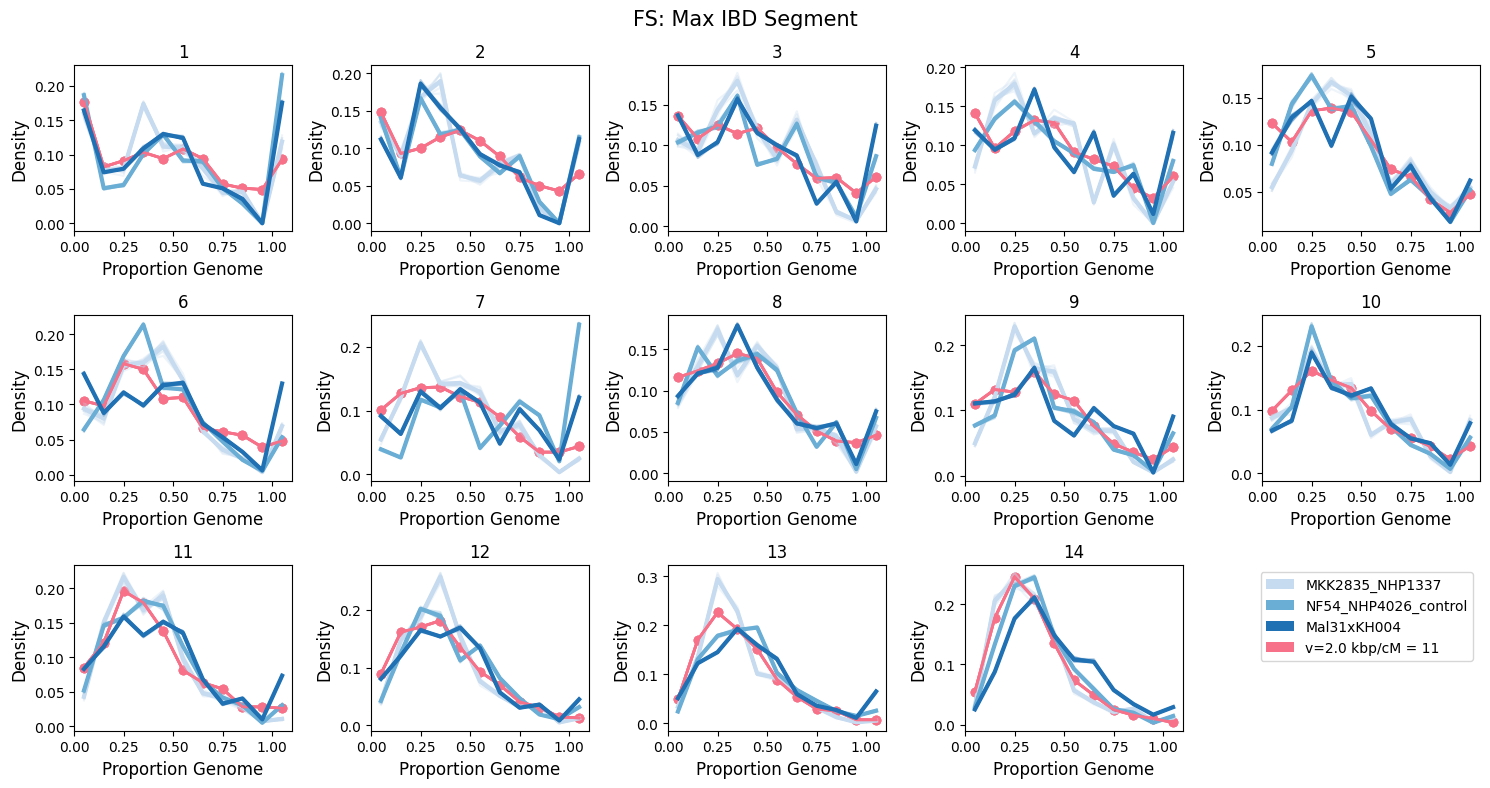

In [397]:
plot_max_ibd_segment_comparison('PC',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11], True)
plot_max_ibd_segment_comparison('FS',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'],[2.], [11], True)

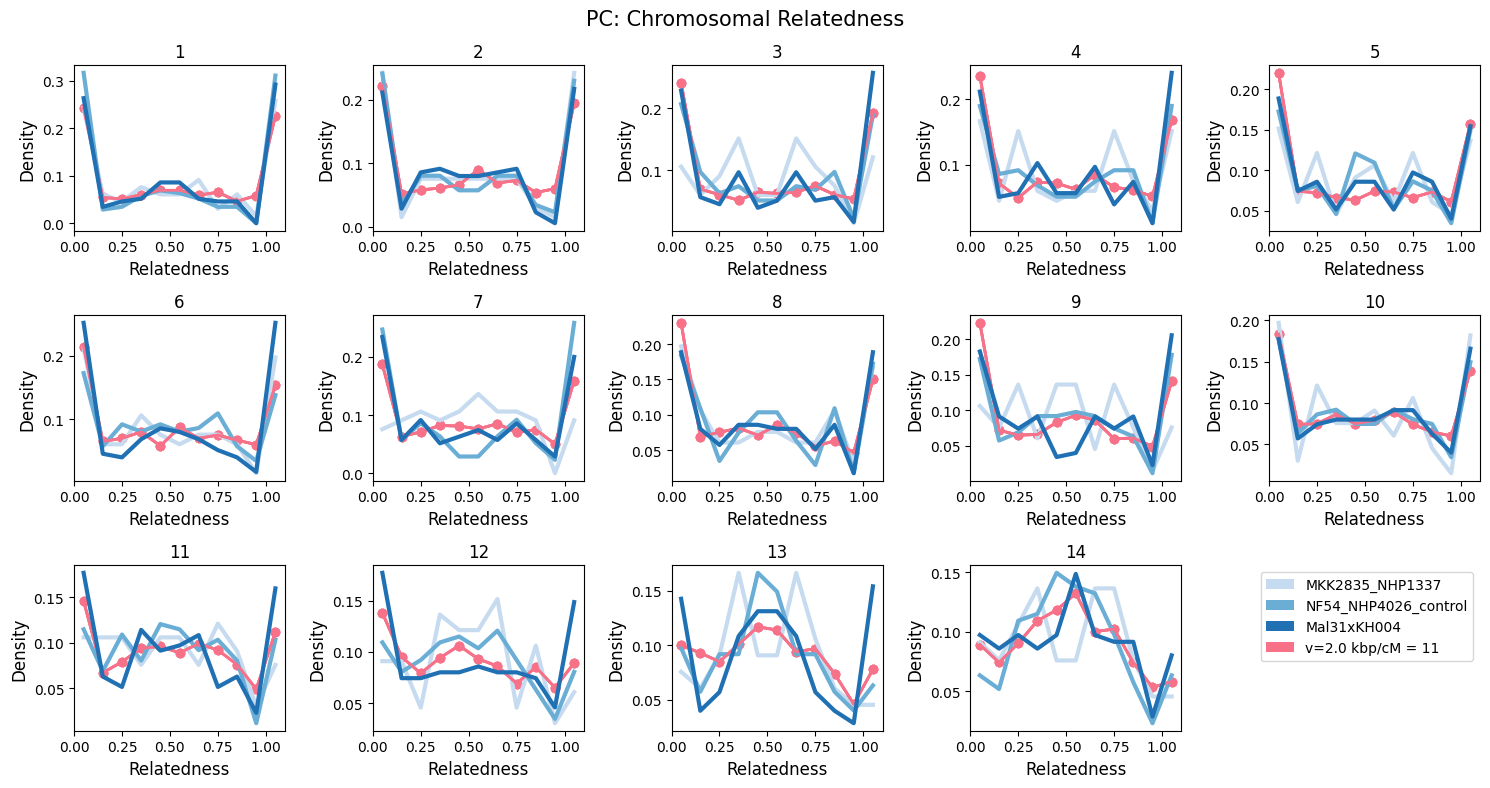

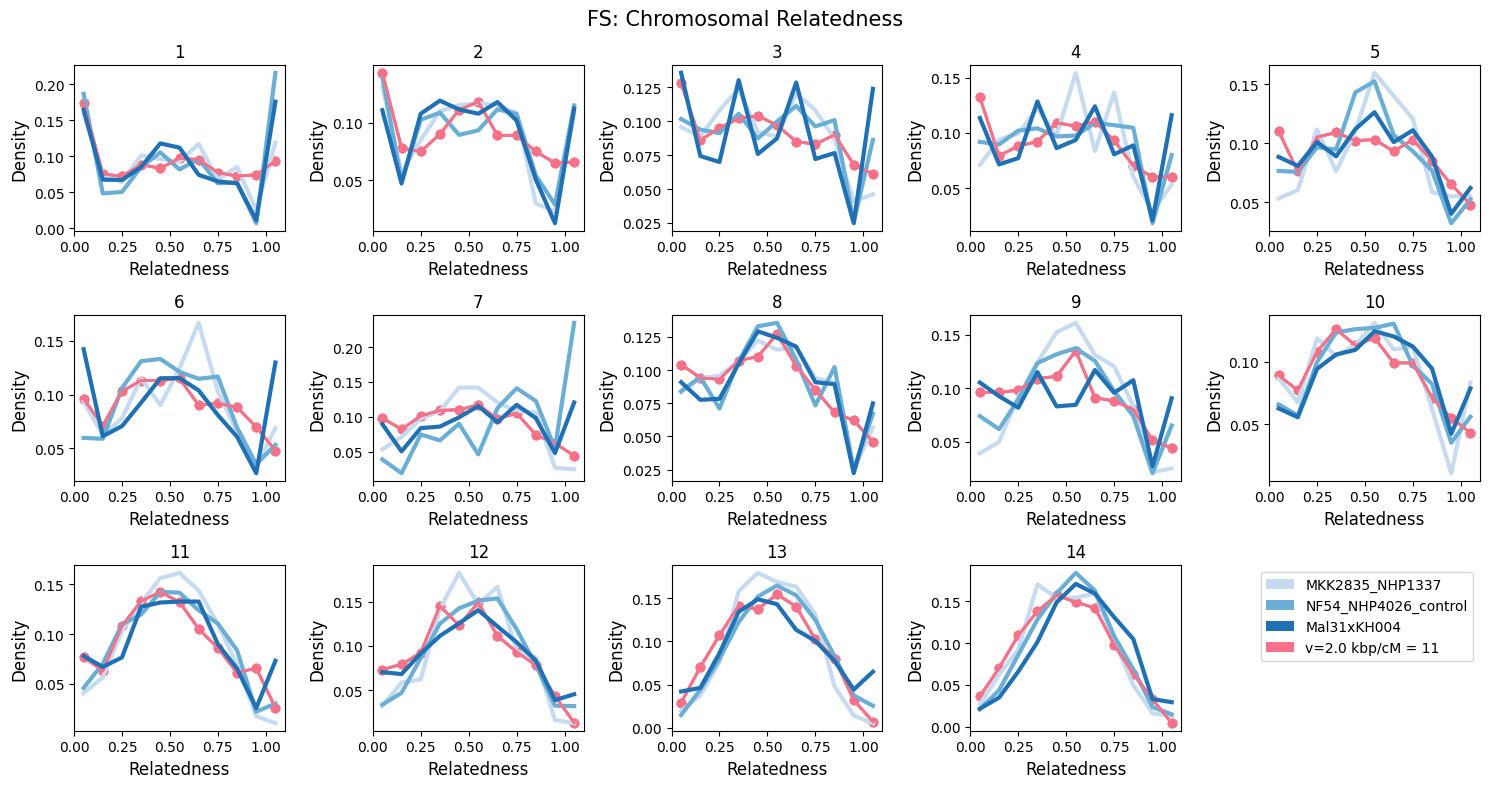

In [419]:
plot_r_chrom_comparison('PC',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11])
plot_r_chrom_comparison('FS',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11])

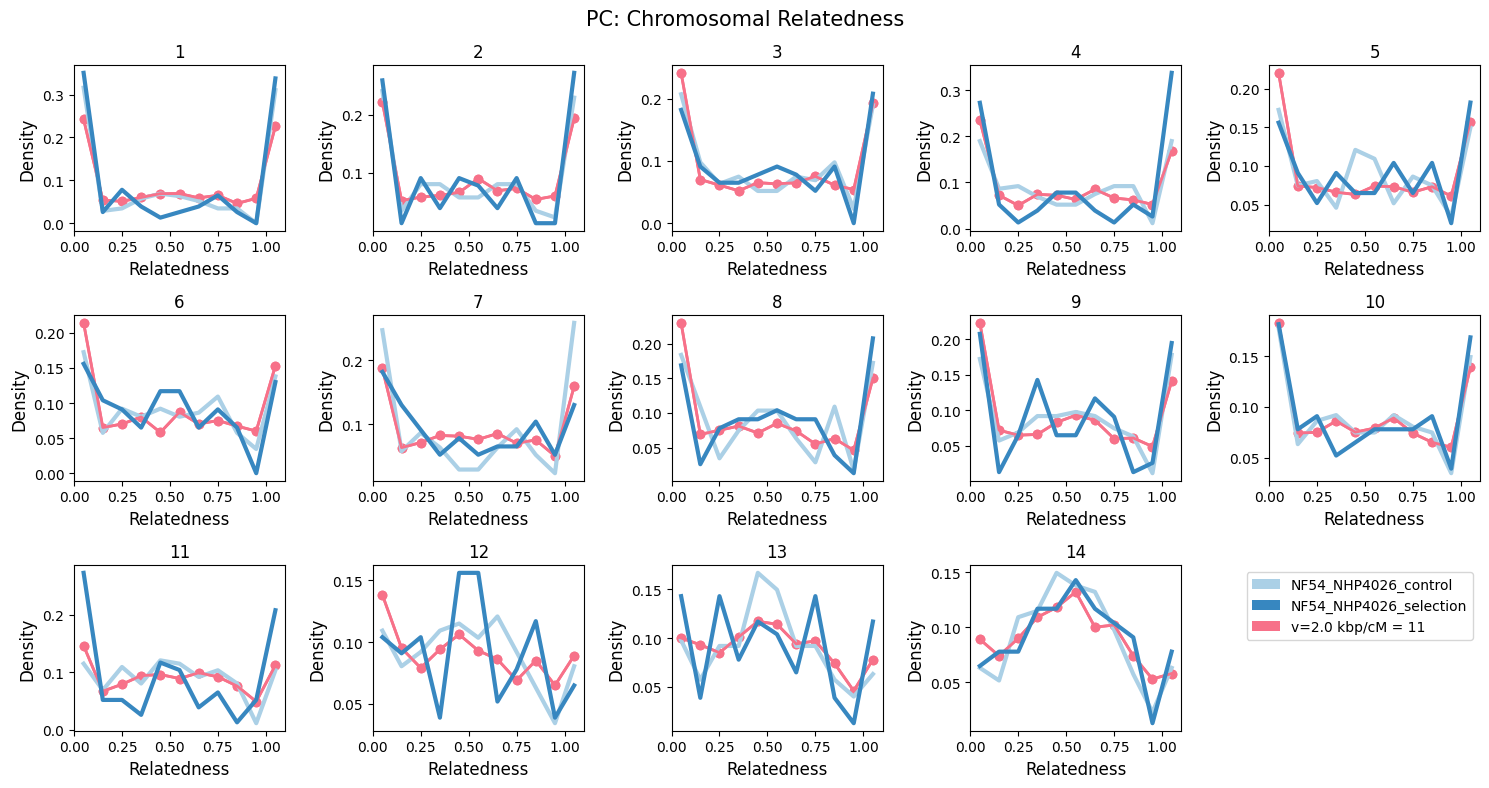

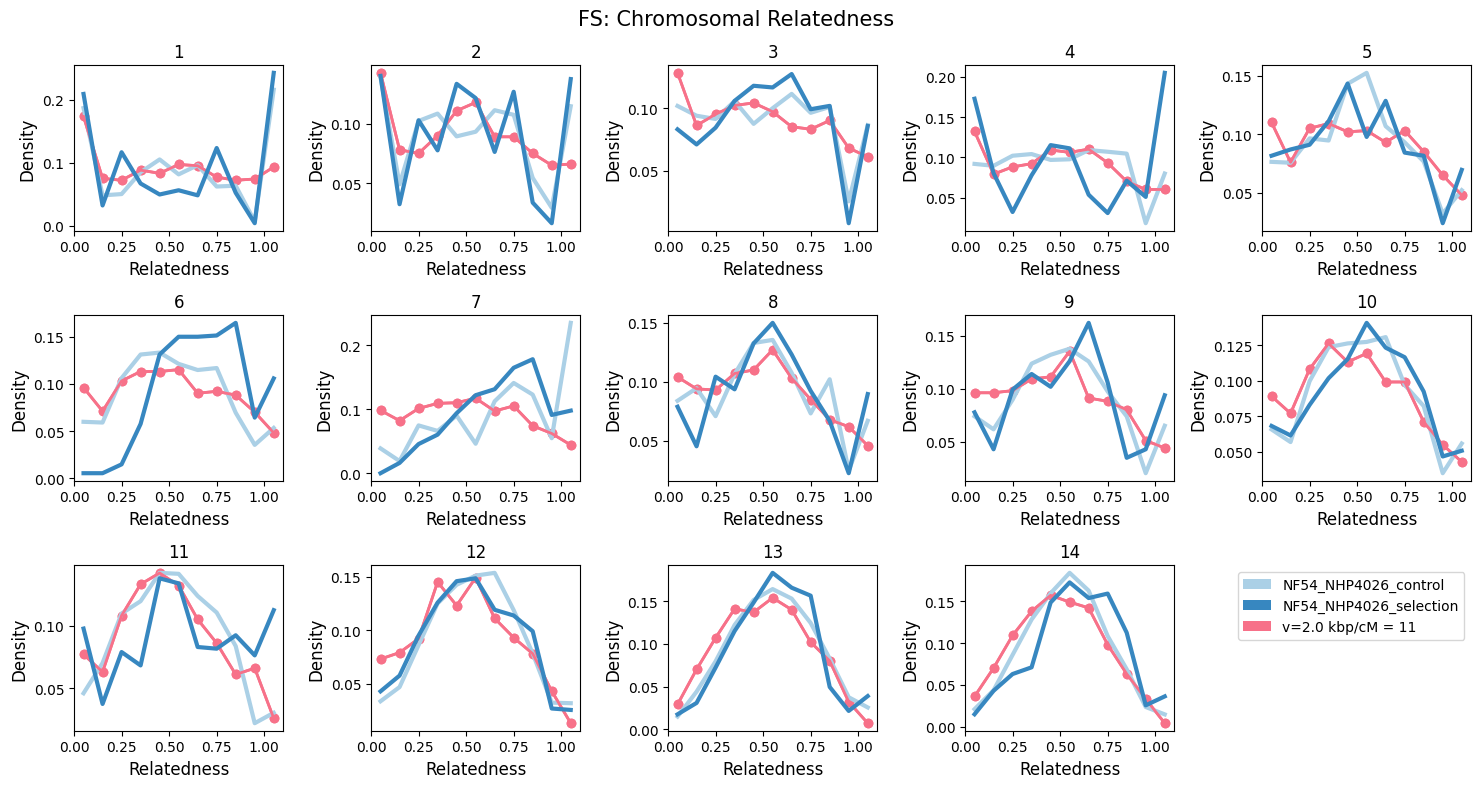

In [393]:
plot_r_chrom_comparison('PC',['NF54_NHP4026_control','NF54_NHP4026_selection'], [2.], [11])
plot_r_chrom_comparison('FS',['NF54_NHP4026_control','NF54_NHP4026_selection'], [2.], [11])

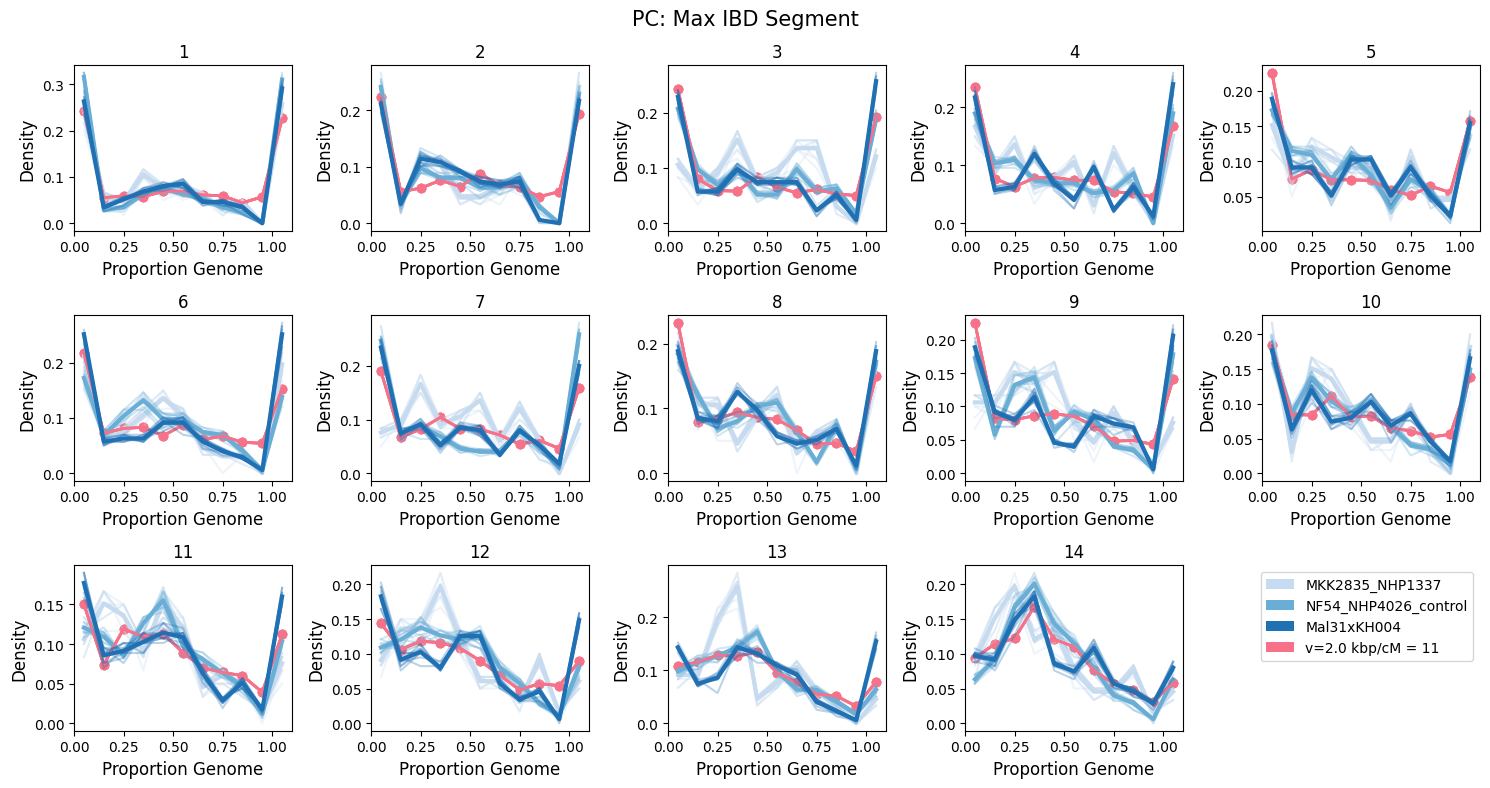

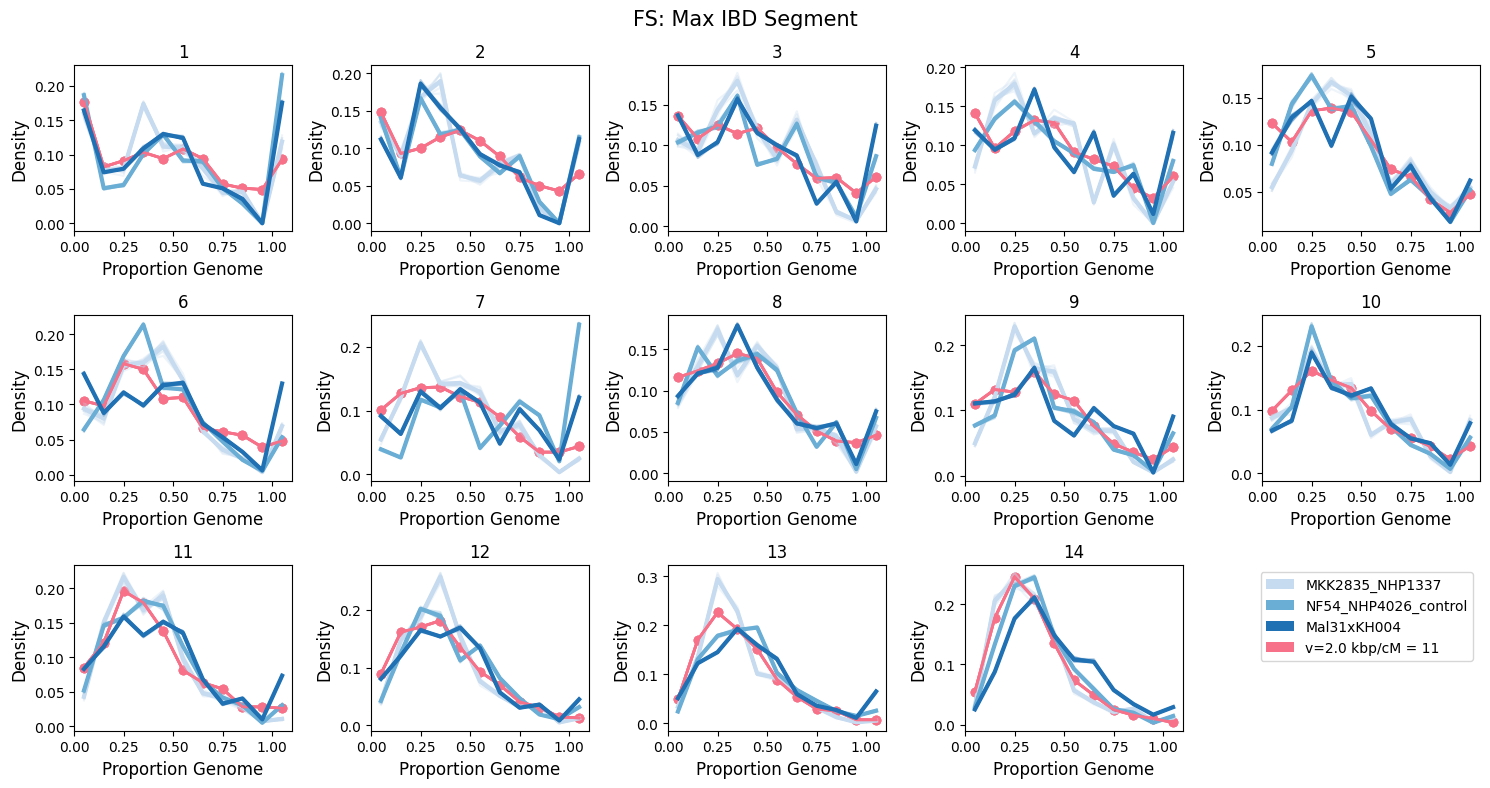

In [416]:
plot_max_ibd_segment_comparison('PC',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11], True)
plot_max_ibd_segment_comparison('FS',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'],[2.], [11], True)

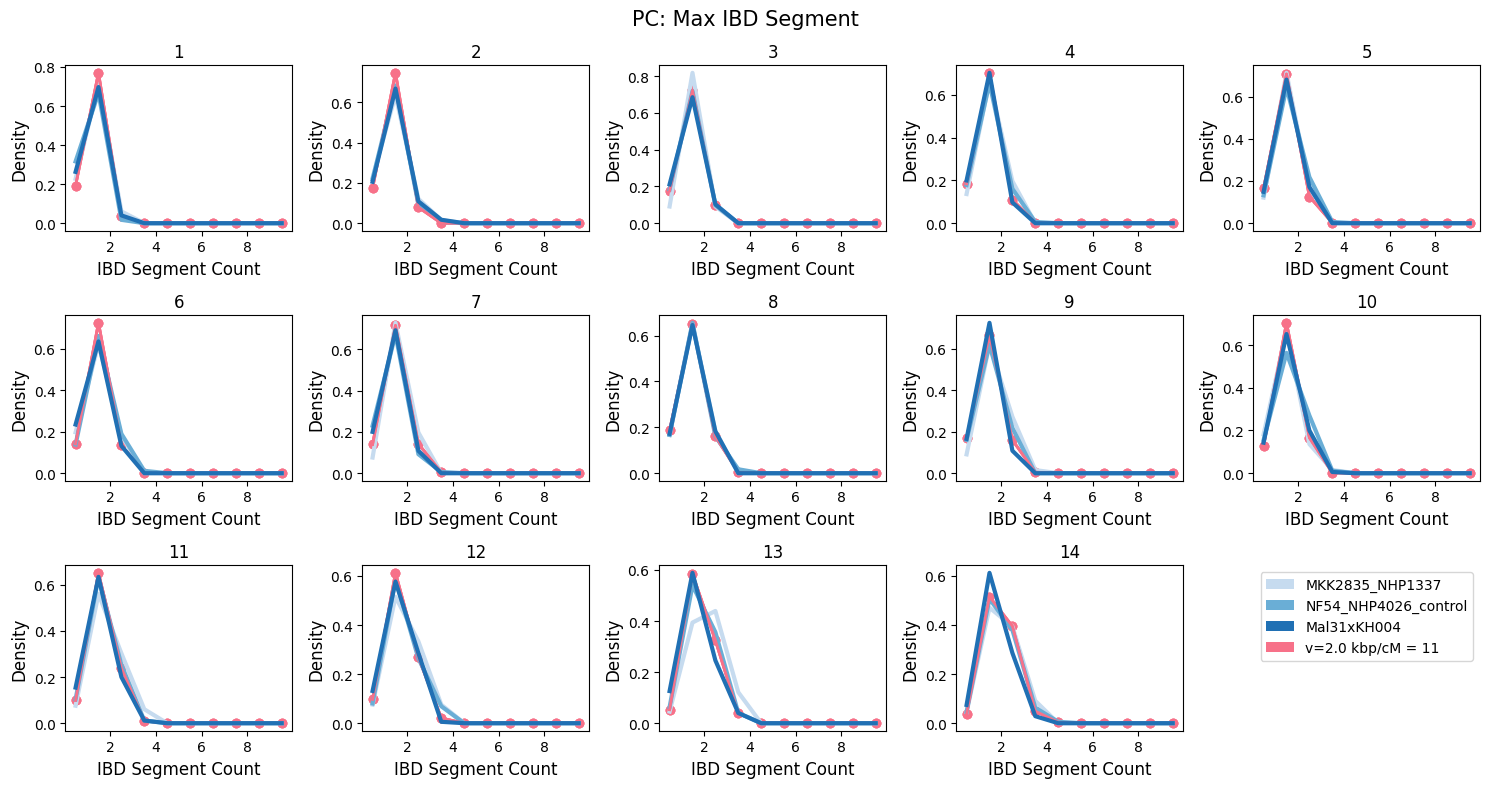

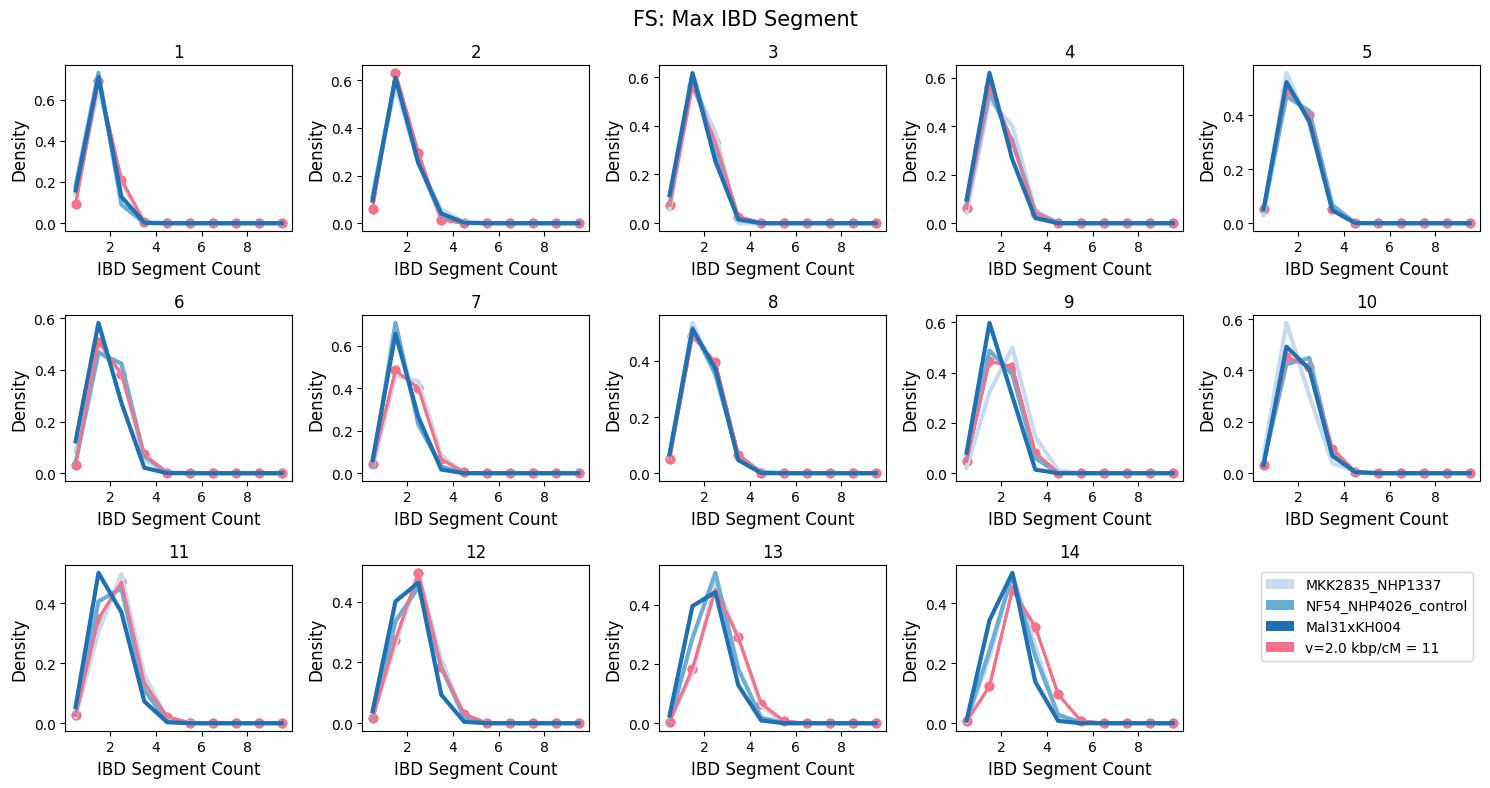

In [391]:
plot_n_ibd_segment_comparison('PC',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11])
plot_n_ibd_segment_comparison('FS',['MKK2835_NHP1337','NF54_NHP4026_control','Mal31xKH004'], [2.], [11])

In [400]:

def plot_kl_divergence(cross_list, v_range = [1., 2.,3.,4.,5.,6.,7.], keep_chromosomes = [chrom for chrom in range(1,15)]):
    kl_divergence_dict = defaultdict(list)
    c_palette = sns.color_palette('husl', len(v_range))
    handles = []
    n_dims = 4
    kbp_cM_range =[kbp for kbp in range(5,20)]
    jackknife_sampling = defaultdict(list)
    for v_idx,v in enumerate(v_range):
        y = [KL_divergence(v,kbp_cM, cross_list, chrom_range = keep_chromosomes) for kbp_cM in kbp_cM_range]
        #print(v, kbp_cM_range[np.argmin(y)], min(y))
        plt.scatter(kbp_cM_range, y ,label=v, color = c_palette[v_idx])
        mymodel_allchrom = np.poly1d(np.polyfit(kbp_cM_range, y, n_dims))
        x_array = np.linspace(5, 20, 100)
        prediction = mymodel_allchrom(x_array)
        #print(v, x_array[np.argmin(prediction)])
        #plt.plot(x_array, mymodel_allchrom(x_array), color = 'black')

        x_array = np.linspace(5, 20, 100)
        jackknife_lines = []
        for index in range(10):
            y = [KL_divergence(v,kbp_cM, cross_list, chrom_range = keep_chromosomes, jacknife_idx = index) for kbp_cM in kbp_cM_range]
            #print(v, kbp_cM_range[np.argmin(y)], min(y))
            plt.scatter(kbp_cM_range, y ,label=v, color = c_palette[v_idx])
            mymodel_allchrom = np.poly1d(np.polyfit(kbp_cM_range, y, n_dims))
            prediction = mymodel_allchrom(x_array)
            jackknife_sampling[v].append((x_array[np.argmin(prediction)], min(prediction)))
            plt.plot(x_array, prediction, color = c_palette[v_idx], alpha = 0.3)
            jackknife_lines.append(prediction)
        plt.plot(x_array, np.mean(jackknife_lines,axis = 0), color = c_palette[v_idx], linewidth = 2, linestyle='-.')

        #plt.plot(x_array, mymodel_allchrom(x_array), color = c_palette[v_idx], alpha = 0.3)
        kl_divergence_dict[v].append(x_array[np.argmin(prediction)])
        handles.append(Patch(color = c_palette[v_idx], label = v))

    plt.legend(title='Interference', handles = handles)
    plt.xlabel('kbp/cM')
    plt.ylabel('Forward KL Divergence')
    plt.ylim(0,10)
    plt.xlim(5,18)
    return jackknife_sampling


In [401]:
cross_comparisons_dict.keys()

dict_keys(['Mal31xKH004', 'MKK2835_NHP1337', 'NF54_NHP4026_control', 'NF54_NHP4026_selection', 'MKK2835_NHP1337|NF54_NHP4026_control', 'Mal31xKH004|NF54_NHP4026_control', 'Mal31xKH004|MKK2835_NHP1337|NF54_NHP4026_control'])

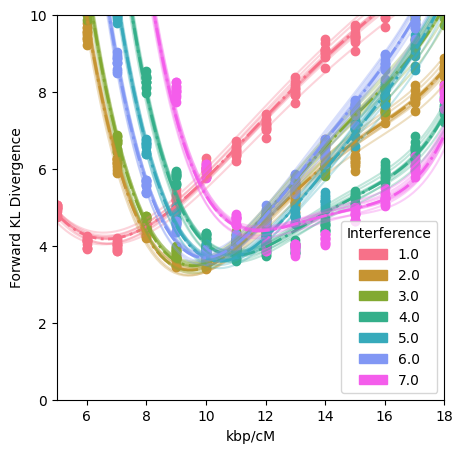

In [402]:
#['Mal31xKH004', 'MKK2835_NHP1337', 'NF54_NHP4026_control','NF54_NHP4026_selection']
params = {}
plt.figure(figsize=(5,5))
params['MKK2835_NHP1337'] = plot_kl_divergence(['MKK2835_NHP1337'])

#plt.subplot(1,2,2)
#neutral_chromosomes = [1,2,3,4,5,6,8,9,10,11,14]
#jackknife_sampling_neutral_chrom = plot_kl_divergence(keep_chromosomes = neutral_chromosomes)


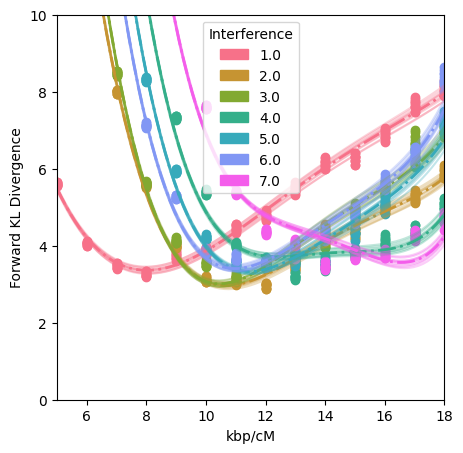

In [403]:
plt.figure(figsize=(5,5))
params['NF54_NHP4026_control']  = plot_kl_divergence(['NF54_NHP4026_control'])

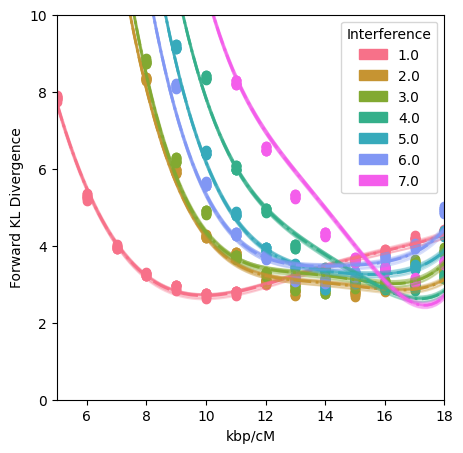

In [404]:
plt.figure(figsize=(5,5))
params['Mal31xKH004']  = plot_kl_divergence(['Mal31xKH004'])

In [422]:
params['Mal31xKH004']

defaultdict(list,
            {1.0: [(9.848484848484848, 2.74293924815521),
              (9.848484848484848, 2.723906351525052),
              (10.0, 2.638108269361773),
              (10.0, 2.730182780383842),
              (10.0, 2.712381693727586),
              (10.0, 2.7394347252973645),
              (9.848484848484848, 2.6770967341145564),
              (10.0, 2.607395360677323),
              (9.848484848484848, 2.724440649262405),
              (9.848484848484848, 2.7246970471708565)],
             2.0: [(16.515151515151516, 2.893381056569382),
              (16.515151515151516, 2.8389636177548425),
              (16.515151515151516, 2.791651875242053),
              (16.515151515151516, 2.8686331037262107),
              (16.515151515151516, 2.847452477324083),
              (16.515151515151516, 2.8709072252868566),
              (16.515151515151516, 2.839409153750154),
              (16.515151515151516, 2.7564533987928144),
              (16.515151515151516, 2.8725454761882

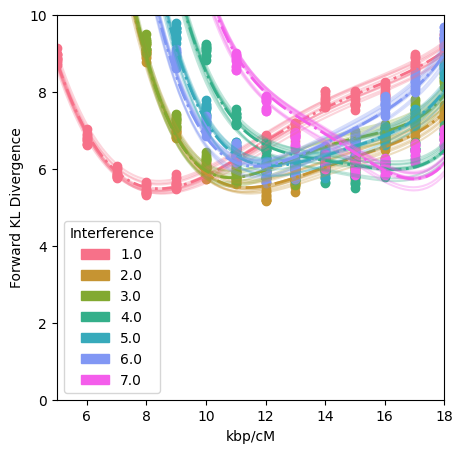

In [405]:
plt.figure(figsize=(5,5))
params['NF54_NHP4026_selection']  = plot_kl_divergence(['NF54_NHP4026_selection'])

In [406]:
params['NF54_NHP4026_selection'] 

defaultdict(list,
            {1.0: [(8.484848484848484, 5.364621966057136),
              (8.333333333333334, 5.492817560918105),
              (8.484848484848484, 5.353100765085323),
              (8.484848484848484, 5.685273868857813),
              (8.333333333333334, 5.621962068371097),
              (8.484848484848484, 5.410066114029917),
              (8.333333333333334, 5.417918215170388),
              (8.484848484848484, 5.590306448189196),
              (8.484848484848484, 5.425000584509),
              (8.484848484848484, 5.443473680515687)],
             2.0: [(11.363636363636363, 5.468398082881322),
              (11.363636363636363, 5.5138461546969495),
              (11.515151515151516, 5.35463327657402),
              (11.363636363636363, 5.705636083322162),
              (11.363636363636363, 5.654071246941797),
              (11.363636363636363, 5.390311508157325),
              (11.212121212121211, 5.4066908556500834),
              (11.363636363636363, 5.61640014094

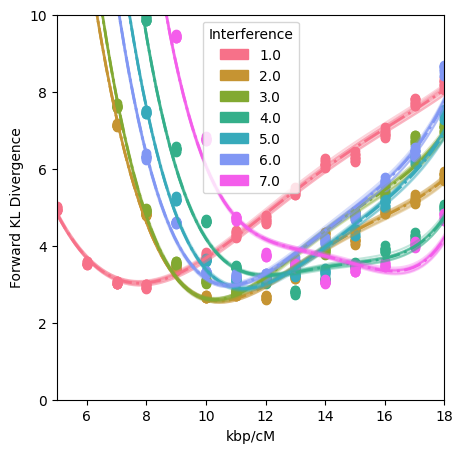

In [407]:
plt.figure(figsize=(5,5))
params['MKK2835_NHP1337|NF54_NHP4026_control']  = plot_kl_divergence(['MKK2835_NHP1337|NF54_NHP4026_control'])

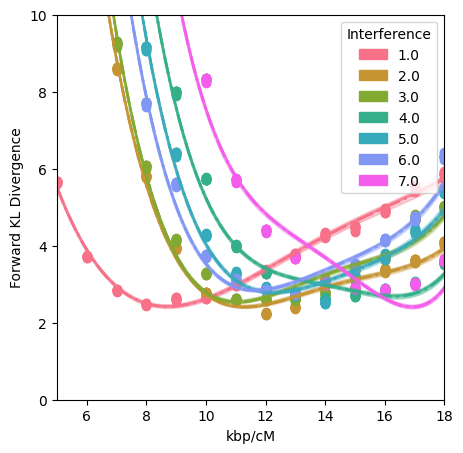

In [408]:
plt.figure(figsize=(5,5))
params['Mal31xKH004|MKK2835_NHP1337|NF54_NHP4026_control']  = plot_kl_divergence(['Mal31xKH004|MKK2835_NHP1337|NF54_NHP4026_control'])



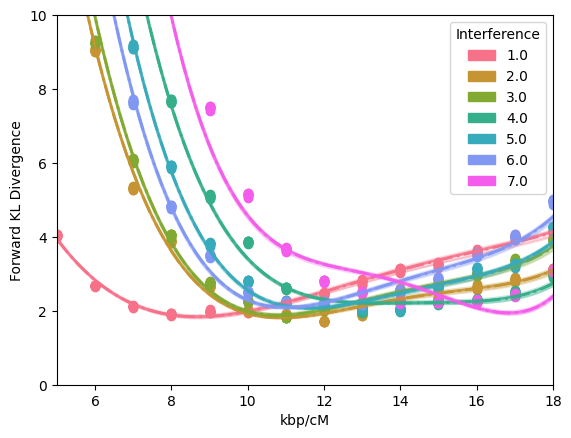

In [415]:
test  = plot_kl_divergence(['Mal31xKH004|MKK2835_NHP1337|NF54_NHP4026_control'],
                          keep_chromosomes = [x for x in range(1,15) if x not in [7,12,14]])
